<a href="https://colab.research.google.com/github/balajisriraj/Twitter-Summary-mini-Project/blob/main/Twitter_Trend_Finder_In_Progress_V0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Flow:

- Connect to Twittter API using the required creds
- Find the Top trending Hashtags
- Then filter the hashtags which are in English language
- Filter Top 3 Hashtags from that
- For these 3 hashtags, fetch 100 Tweets individually
- Combain all the 100 tweets into one big corpus
- Do basic Data Cleaning & Processing for better Tokenization
- Using Text to Text transformer t5 model Summarize the tweets
- Show Summarized text output for each Hashtag

In [345]:
!pip install googletrans
! pip install transformers

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 3.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 34.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8afa79e45f2c002676c0fb74b2ea84253bb3db64388730aa8c4f24cb4f8df5d3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Import Python Modules

In [353]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from googletrans import Translator
import datetime
import copy
import string
import re
import preprocessor as p
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import os
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY,p.OPT.MENTION)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cuda')

In [354]:
#Past the keys from your local drive


In [355]:
# Consumer key authentication(consumer_key,consumer_secret can be collected from our twitter developer profile)
auth = OAuthHandler(consumer_key, consumer_secret)
# Access key authentication(access_token,access_token_secret can be collected from our twitter developer profile)
auth.set_access_token(access_token, access_token_secret)
# Set up the API with the authentication handler
api = API(auth)

In [356]:
WOE_ID = 2459115 # Where on Earth id can be extracted from https://nations24.com/world-wide
lan_find = Translator() # for finding teh language of the hashtags

In [357]:
def get_location_trends(locations, auth,n_hashtags,lang):
  api = API(auth)
  trends = api.trends_place(locations)
  data = trends[0]
  trends_data = data['trends']
  global tred_data
  tred_data = []
  for info in trends_data:
    tred_data.append([info['name'],info['tweet_volume'],lan_find.detect(info['name']).lang ] )
  tred_data = pd.DataFrame(tred_data, columns = list(['Hashtag',
                                                    'Tweet_Volume', 'Language'])).sort_values(by = ['Tweet_Volume'],ascending = False)
  #select english language trends
  tred_data = tred_data[tred_data.Language == lang]
  #select top 3 trends
  tred_data = tred_data.nlargest(n_hashtags,columns=['Tweet_Volume'])
  return tred_data

In [358]:
df_trending = get_location_trends(WOE_ID,auth,3,'en')
df_trending

,Hashtag,Tweet_Volume,Language
0,Covid,6188244.0,en
45,#BTSWEEK,1185230.0,en
44,#BTSMONTH,641002.0,en


In [410]:
#hashtag_list = list(df_trending['Hashtag'])
hashtag_list = list(['#SatyagrahaForOurDaughters'])

In [411]:
def extract_tweets_for_htags(no_of_tweets):
  dict_of_df = {} 
  for htag in hashtag_list:
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    tweets = tweepy.Cursor(api.search,q=htag,lang="en",since=today).items(no_of_tweets) #Extracting tweets for the htag
    tweets= [tweet.text for tweet in tweets] # Saving the tweets as list
    
    
    key_name = 'df_htag_'+str(htag)
    dict_of_df[key_name] = copy.deepcopy(tweets)
  return dict_of_df

In [413]:
dict_of_df = extract_tweets_for_htags(500) #Dictionary that has data for all top three hashtags
hashtag_df_list = dict_of_df.keys() #List contains individual the key names for accessing the data inside the dictionary

In [414]:
hashtag_df_list

dict_keys(['df_htag_#SatyagrahaForOurDaughters'])

In [415]:
def remove_punct(text):
    clean_text = []
    for tweet in text:
      tweet = re.sub(r"http\S+", "", tweet)
      text  = "".join([char for char in tweet if char not in string.punctuation])
      text = ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text))
      text = text.replace('RT','').strip()
      clean_text.append(text)
    return clean_text
  

In [416]:
def clean_tweet():
  processed_data_dict = {}
  for htag in hashtag_df_list:
    df = dict_of_df[htag]
    df = remove_punct(df)
    key_name = str(htag)
    processed_data_dict[key_name] = copy.deepcopy(df)
  
  return processed_data_dict 

In [417]:
clean_data = clean_tweet()

In [418]:
clean_data

{'df_htag_#SatyagrahaForOurDaughters': ['MahilaCongress She is priyankagandhi She fights for injustice A mark of a true leader  SatyagrahaForOurDaughters',
  'INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters',
  'INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters',
  'RashidShaquib All abusive systems are facilitated by bystanderswhose awareness of what is disavowed is always partialresulting in a',
  'INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters',
  'ShashiTharoor Explained to the media why in a democracy it is perfectly justified for an Opposition party to fight for justice in the',
  'ShashiTharoor With traffic gridlocked on the DelhiNoida Expressway I walked the last fifteen minutes to where the Police are blockin',
  'INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters',
  'INCIndia There 

In [419]:
df_clean_data = pd.DataFrame.from_dict(clean_data)

In [420]:
htags = df_clean_data.columns

In [421]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))

<IPython.core.display.Javascript object>

Word Clod for the trending hashtag df_htag_#SatyagrahaForOurDaughters 



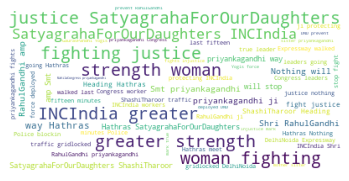

Original text preprocessed: 
 MahilaCongress She is priyankagandhi She fights for injustice A mark of a true leader  SatyagrahaForOurDaughters, INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters, INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters, RashidShaquib All abusive systems are facilitated by bystanderswhose awareness of what is disavowed is always partialresulting in a, INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters, ShashiTharoor Explained to the media why in a democracy it is perfectly justified for an Opposition party to fight for justice in the, ShashiTharoor With traffic gridlocked on the DelhiNoida Expressway I walked the last fifteen minutes to where the Police are blockin, INCIndia There is no greater strength than a woman fighting for justice SatyagrahaForOurDaughters, INCIndia There is no greater strength than a woman fightin

In [422]:
for htag in htags:
  temp =  df_clean_data[htag].str.cat(sep=', ') # Select a column insert i here
  #Word Cloud
  print(f'Word Clod for the trending hashtag {htag} \n') 
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words=200,max_font_size=40, random_state=42).generate(str(temp))
  fig = plt.figure(1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  preprocess_text = temp.strip().replace("\n","")
  t5_prepared_Text = "summarize: "+preprocess_text
  print ("Original text preprocessed: \n", preprocess_text)
  tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt",  truncation=True)
  # summmarize 
  # summary_ids = model.generate(tokenized_text,max_length=100, num_beams=5,no_repeat_ngram_size=2, 
  #                               num_return_sequences=5, do_sample=True, top_k=50,temperature=0.7,
  #                              early_stopping=True)
  
  summary_ids = model.generate(
    tokenized_text,
    do_sample=True, 
    max_length=75, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
                            )
  
  output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  print(f"\n\nSummarized text for {htag}: \n",output)
  print('*' *100)
  print('\n')
print("Completed")